In [2]:
import pandas as pd
import numpy as np

# Load data

In [3]:
covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
covid.head(2)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN


<AxesSubplot:xlabel='date'>

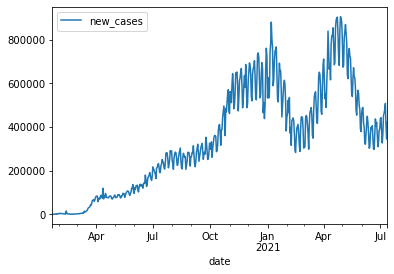

In [4]:
y = covid[(covid['location']=='World')]
y.index = pd.to_datetime(y['date'])
y = y.asfreq('D')
y = y[['new_cases']]
y.plot()

# Distribution focused

[DummyRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html)

_DummyRegressor is a regressor that makes predictions using simple rules._

_This regressor is useful as a simple baseline to compare with other (real) regressors. Do not use it for real problems._

In [5]:
#https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html
from sklearn.dummy import DummyRegressor

In [6]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(y, y)

DummyRegressor()

In [7]:
y.mean()

new_cases    347143.789963
dtype: float64

In [8]:
y['mean'] = dummy_regr.predict(y)

<AxesSubplot:xlabel='date'>

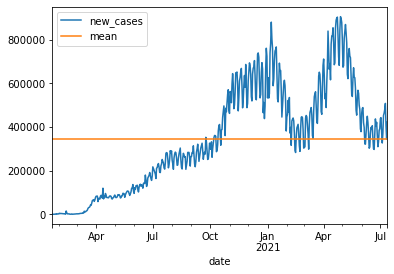

In [9]:
y.plot()

# Naive

[NaiveForecaster](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.naive.NaiveForecaster.html)

_Make predictions using simple strategies_

In [11]:
#https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.naive.NaiveForecaster.html
#!pip install sktime==0.6.1
from sktime.forecasting.naive import NaiveForecaster
#https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.base.ForecastingHorizon.html
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

In [12]:
strategy = 'drift'
forecaster = NaiveForecaster(strategy=strategy, window_length=30, sp=7)
forecaster.fit(y['new_cases'])

/Users/nick/opt/anaconda3/envs/ambient_pop/lib/python3.7/site-packages/sktime/forecasting/naive.py:122: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn("For the `drift` strategy, the `sp` value will be ignored.")


NaiveForecaster(sp=7, strategy='drift', window_length=30)

In [13]:
h = 30
fh = ForecastingHorizon(pd.date_range(max(y.index), periods=h, freq="d", closed='right'), is_relative=False)

In [14]:
y_pred = forecaster.predict(fh=fh)

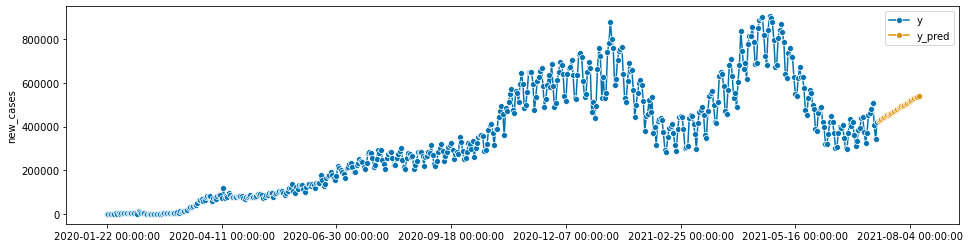

In [15]:
import matplotlib.pyplot as plt
plot_series(y['new_cases'], y_pred, labels=["y", "y_pred"])
plt.savefig(f'naive_{strategy}.png')

# Expert regressor

_Very simple example of manually comparing a prediction to some benchmark (here just compare to the mean)_

In [18]:
from sklearn.base import BaseEstimator, RegressorMixin

class ExpertRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, expert_value=400000):
        self.expert_value = expert_value

    def fit(self, X, y):
        self.mean = np.mean(X.values)
        return self

    def predict(self, X):
        return min(self.expert_value, self.mean)

    # def get_params(self, deep=True):
    #     return {'expert_value': self.expert_value}

    # def set_params(self, **parameters):
    #     for parameter, value in parameters.items():
    #         setattr(self, parameter, value)
    #     return self

<AxesSubplot:xlabel='date'>

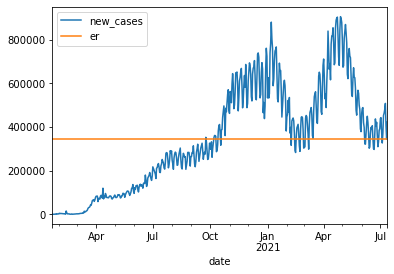

In [19]:
er = ExpertRegressor()
er.fit(y[['new_cases']], y['new_cases'])
y['er'] = er.predict(y[['new_cases']])
y[['new_cases', 'er']].plot()

<AxesSubplot:xlabel='date'>

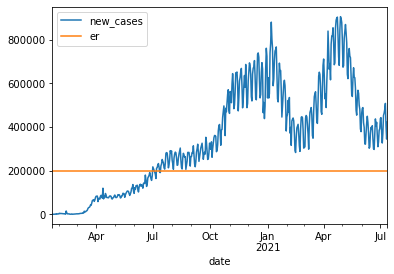

In [20]:
er = ExpertRegressor(expert_value=200000)
er.fit(y[['new_cases']], y['new_cases'])
y['er'] = er.predict(y)
y[['new_cases', 'er']].plot()